In [1]:
import sys, os
BIN = os.path.expanduser("../../..")
sys.path.append(BIN)

In [2]:
import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
import pprint

from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.particles.slicing import UniformBinSlicer, UniformChargeSlicer, ModeIsUniformCharge

PyHEADTAIL v1.2.0-153-gbc0ea69a06-dirty




In [3]:
# HELPERS

def plot_slice_set_structure(axes, bunch, slice_set):
    '''Plot basic structure of SliceSet - z_bins, z_centers,
    n_macroparticles_per_slice.
    '''
    [axes.axvline(z, c='b', lw=2) for z in slice_set.z_bins[1:]]
    axes.axvline(slice_set.z_bins[0], c='b', lw=2,
                 label='z_bins')
    [axes.axvline(z, c='b', ls='dashed') for z in
        slice_set.z_centers[1:]]
    axes.axvline(slice_set.z_centers[0], c='b', ls='dashed',
                 label='z_centers')
    axes.plot(slice_set.z_centers,
              slice_set.n_macroparticles_per_slice,
              'x', color='black', ms=10, mew=2,
              label='z_centers vs. n_macroparticles')
    y_up =  max(slice_set.n_macroparticles_per_slice)
    y_up += 0.1 * y_up
    axes.set_ylim((0,y_up))
    axes.set_xlim(((1+0.1) * min(bunch.z), (1+0.1) * max(bunch.z)))

def plot_particle_indices_of_slice(axes, bunch, slice_set):
    '''Show all particles in a z vs. slice_index plot. Add SliceSet
    and slice boundaries. particles_within_cuts are overlayed
    to see if they have been correctly determined.
    '''
    z_cut_tail = slice_set.z_cut_tail
    z_cut_head = slice_set.z_cut_head
    part_in_cuts = slice_set.particles_within_cuts
    six = slice_set.slice_index_of_particle

    axes.plot(six, bunch.z, '.r', ms=12, label='All particles')
    axes.plot(six.take(part_in_cuts), bunch.z.take(part_in_cuts), '.g',
             label='particles_within_cuts')
    axes.axhline(z_cut_tail, color='b', ls='dashed',
                label='SliceSet boundaries')
    axes.axhline(z_cut_head, color='b', ls='dashed')
    [axes.axhline(z, color='b', ls='dashed') for z in
        slice_set.z_bins]
    axes.axvline(0, color='m', label='slices 0 and n-1')
    axes.axvline(slice_set.n_slices-1, color='m')
    axes.set_xlim((min(slice_set.slice_index_of_particle)-1,
                   max(slice_set.slice_index_of_particle)+1))
    axes.legend(loc='lower right')

def test_particle_indices_of_slice(bunch, slice_set):
    '''Get particle_indices_of_slice for specific slice index. Apply
    'inverse function' slice_index_of_particle to get back slice_index
    if everything works correctly.
    '''
    all_pass = True
    for i in xrange(slice_set.n_slices):
        pix_slice = slice_set.particle_indices_of_slice(i)
        six_pix = slice_set.slice_index_of_particle[pix_slice]
        if (six_pix != i).any():
            all_pass = False

    if all_pass:
        print ('  Particle_indices_of_slice <-> slice_index_of_particle PASSED')
    if not all_pass:
        print ('  Particle_indices_of_slice and slice_index_of_particle FAILED')

# TURN THIS INTO A PROPER CHECK BY ITSELF:
def slice_check_statistics(slice_set):
    '''Test if statistics functions are executable. No value
    checking
    '''
    slice_set.mean_x
    slice_set.sigma_x
    slice_set.epsn_x
    slice_set.mean_y
    slice_set.sigma_y
    slice_set.epsn_y
    slice_set.mean_z
    slice_set.sigma_z
    slice_set.epsn_z
    slice_set.mean_xp
    slice_set.mean_yp
    slice_set.mean_dp
    slice_set.sigma_dp
    
def plot_results_uniform_bin(bunch, uniform_bin_slice_set):
    # Plot environment
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    plot_slice_set_structure(axes=ax1, bunch=bunch,
                             slice_set=uniform_bin_slice_set)
    if n_sigma_z == None:
        ax1.hist(bunch.z, uniform_bin_slice_set.n_slices, color='r', alpha=0.6,
                 label='matplotlib hist')
    ax1.legend(loc='lower left')

    plot_particle_indices_of_slice(axes=ax2, bunch=bunch,
                                   slice_set=uniform_bin_slice_set)

    ax1.set_xlabel('z [m]')
    ax1.set_ylabel('# macroparticles')
    ax2.set_xlabel('slice index')
    ax2.set_ylabel('z [m]')
    plt.show()
    
def plot_results_uniform_charge(bunch, uniform_charge_slice_set):
    # Plot environment
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    plot_slice_set_structure(axes=ax1, bunch=bunch,
                             slice_set=uniform_charge_slice_set)

    n_particles_within_cuts = len(uniform_charge_slice_set.particles_within_cuts)
    ax1.axhline(n_particles_within_cuts / float(uniform_charge_slice_set.n_slices),
                c='r', ls='dashed', lw=2,
                label='expected number of particles per slice')
    ax1.legend(loc='lower left')

    plot_particle_indices_of_slice(axes=ax2, bunch=bunch,
                                   slice_set=uniform_charge_slice_set)

    ax1.set_xlabel('z [m]')
    ax1.set_ylabel('# macroparticles')
    ax2.set_xlabel('slice index')
    ax2.set_ylabel('z [m]')
    plt.show()

def call_slice_set_attributes(bunch, slice_set, line_density_testing=True):
    # Call all the properties / attributes / methods.
    print 'z_cut_head', slice_set.z_cut_head
    print 'z_cut_tail', slice_set.z_cut_tail
    print 'z_centers', slice_set.z_centers
    print 'n_slices', slice_set.n_slices
    print 'slice_widths', slice_set.slice_widths
    print 'slice_positions', slice_set.slice_positions
    print 'n_macroparticles_per_slice', slice_set.n_macroparticles_per_slice
    print 'particles_within_cuts', slice_set.particles_within_cuts
    print 'particle_indices_by_slice', slice_set.particle_indices_by_slice

    test_particle_indices_of_slice(bunch, slice_set)
    slice_check_statistics(slice_set)

    if line_density_testing:
        print 'line_density_derivative_gauss', slice_set.lambda_prime_bins()
        print 'line_density_derivative', slice_set.lambda_prime_bins(smoothen_before=False, smoothen_after=False)

    
def call_slicer_attributes():
    pass

def clean_bunch(bunch):
    bunch.clean_slices()

In [4]:
# Basic parameters.
n_macroparticles = 500

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
alpha_0 = [0.0003225]

In [7]:
# general simulation parameters
n_particles = 10000

# machine parameters
circumference = 157.
inj_alpha_x = 0
inj_alpha_y = 0
inj_beta_x = 5.9 # in [m]
inj_beta_y = 5.7 # in [m]
Qx = 5.1
Qy = 6.1
gamma_tr = 4.05
alpha_c_array = [gamma_tr**-2]
V_rf = 8e3 # in [V]
harmonic = 1
phi_offset = 0 # measured from aligned focussing phase (0 or pi)
pipe_radius = 5e-2

# beam parameters
Ekin = 1.4e9 # in [eV]
intensity = 1.684e12
epsn_x = 2.5e-6 # in [m*rad]
epsn_y = 2.5e-6 # in [m*rad]
epsn_z = 1.2 # 4pi*sig_z*sig_dp (*p0/e) in [eVs]

# calculations
gamma = 1 + e * Ekin / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)
eta = alpha_c_array[0] - gamma**-2
if eta < 0:
    phi_offset = np.pi - phi_offset
Etot = gamma * m_p * c**2 / e
p0 = np.sqrt(gamma**2 - 1) * m_p * c
Qs = np.sqrt(np.abs(eta) * V_rf / (2 * np.pi * beta**2 * Etot))
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)
turn_period = circumference / (beta * c)

bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_particles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=circumference,
        alpha_x=inj_alpha_x, beta_x=inj_beta_x, epsn_x=epsn_x,
        alpha_y=inj_alpha_y, beta_y=inj_beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)

# CLI-style tests (turn into unittests...)

Call all the properties / attributes of the SliceSet and Slicer.
Note that most of them are also called and actually checked for
their values in the visual checks below.
particle_indices_of_slice and slice_index_of_particle are checked
by the method test_particle_indices_of_slice(bunch, slice_set).
Stats are checked by method slice_set_statistics(bunch, slice_set).

In [8]:
# Uniform bin slicer
n_slices = 10
n_sigma_z = 2
uniform_bin_slicer = UniformBinSlicer(n_slices, n_sigma_z)

# Request slice_set from bunch with the uniform_bin_slicer config.
print 'bunch._slice_sets', bunch._slice_sets
uniform_bin_slice_set = bunch.get_slices(uniform_bin_slicer, statistics=True)
print 'bunch._slice_sets', bunch._slice_sets

print '\n UNIFORM BIN SLICE SET, NSIGMAZ=2, 10 SLICES \n'
print 'slicer.config', uniform_bin_slicer.config
call_slice_set_attributes(bunch, uniform_bin_slice_set)
#call_slicer_attributes(uniform_bin_slice_set)

# Let bunch remove the slice_set.
bunch.clean_slices()
print 'bunch._slice_sets', bunch._slice_sets

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformBinSlicer object at 0x111a2bad0>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x1117aa750>}

 UNIFORM BIN SLICE SET, NSIGMAZ=2, 10 SLICES 

slicer.config ('uniform_bin', 10, 2, None)
z_cut_head 23.1031482231
z_cut_tail -22.9447282057
z_centers [-20.64233438 -16.03754674 -11.4327591   -6.82797146  -2.22318381
   2.38160383   6.98639147  11.59117912  16.19596676  20.8007544 ]
n_slices 10
slice_widths [ 4.60478764  4.60478764  4.60478764  4.60478764  4.60478764  4.60478764
  4.60478764  4.60478764  4.60478764  4.60478764]
slice_positions [   0  313  920 1837 3188 4741 6371 7698 8655 9239 9524]
n_macroparticles_per_slice [ 313  607  917 1351 1553 1630 1327  957  584  285]
particles_within_cuts [   0    1    2 ..., 9997 9998 9999]
particle_indices_by_slice [  11   33   68 ..., 9917 9952 9986]
  Particle_indices_of_slice <-> slice_index_of_particle PASSED
line_density_derivative_gauss [  1.72261001e-09   1.7694

In [9]:
# Uniform charge slicer
n_slices = 10
n_sigma_z = 2

clean_bunch(bunch)

uniform_charge_slicer = UniformChargeSlicer(n_slices, n_sigma_z)
uniform_charge_slice_set = bunch.get_slices(uniform_charge_slicer, statistics=True)

print uniform_charge_slice_set.mode

print '\n UNIFORM CHARGE SLICE SET, NSIGMAZ=2, 10 SLICES \n'
print 'slicer.config', uniform_charge_slicer.config

call_slice_set_attributes(bunch, uniform_charge_slice_set, line_density_testing=False)

print ('\n\n---\n\n')       


uniform_charge

 UNIFORM CHARGE SLICE SET, NSIGMAZ=2, 10 SLICES 

slicer.config ('uniform_charge', 10, 2, None)
z_cut_head 23.1031482231
z_cut_tail -22.9447282057
z_centers [-18.22980826 -11.2085133   -7.24591023  -4.10944373  -1.25441793
   1.46566137   4.19305029   7.30320493  11.27646814  18.31241094]
n_slices 10
slice_widths [ 9.42983989  4.61275004  3.3124561   2.96047691  2.74957468  2.69058391
  2.76419393  3.45611535  4.49041106  9.58147456]
slice_positions [   0  952 1905 2857 3810 4763 5715 6667 7619 8571 9524]
n_macroparticles_per_slice [952 953 952 953 953 952 952 952 952 953]
particles_within_cuts [   0    1    2 ..., 9997 9998 9999]
particle_indices_by_slice [  11   21   33 ..., 9952 9966 9986]
  Particle_indices_of_slice <-> slice_index_of_particle PASSED


---




In [10]:
# Other cases. When are slicers equal?
n_slices = 10
n_sigma_z = 2
uniform_bin_slicer = UniformBinSlicer(n_slices, n_sigma_z)
uniform_charge_slicer = UniformChargeSlicer(n_slices, n_sigma_z)

if not uniform_charge_slicer != uniform_bin_slicer:
    raise Exception('Expected uniform charge slicer and uniform bin slicer to be different!')
else:
    print "Test passed."

Test passed.


In [11]:
# Other cases. When are slicers equal?
n_slices = 10
n_sigma_z = 2
uniform_bin_slicer = UniformBinSlicer(n_slices, n_sigma_z)
uniform_bin_slicer_2 = UniformBinSlicer(n_slices, n_sigma_z)

if not uniform_bin_slicer_2 == uniform_bin_slicer:
    raise Exception('Expected two uniform charge slicer instances with same configuration to be equal!')
else:
    print "Test passed."

Test passed.


In [37]:
# Does bunch slice_set management work?
n_slices = 10
n_sigma_z = 2

clean_bunch(bunch)

uniform_charge_slicer = UniformChargeSlicer(n_slices, n_sigma_z)
uniform_bin_slicer = UniformBinSlicer(n_slices, n_sigma_z)

print bunch._slice_sets
uniform_charge_slice_set = bunch.get_slices(uniform_charge_slicer)
print bunch._slice_sets
uniform_bin_slice_set = bunch.get_slices(uniform_bin_slicer)
uniform_charge_slice_set = bunch.get_slices(uniform_charge_slicer)
print bunch._slice_sets

bunch.clean_slices()
print bunch._slice_sets

if not len(bunch._slice_sets) == 0:
    raise Exception('Expected empty bunch._slice_sets after bunch.clean_slices()!')
else:
    print "\n\nTest passed."

{}
{<PyHEADTAIL.particles.slicing.UniformChargeSlicer object at 0x7f5a86e33910>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7f5a5dced110>}
{<PyHEADTAIL.particles.slicing.UniformChargeSlicer object at 0x7f5a86e33910>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7f5a5dced110>, <PyHEADTAIL.particles.slicing.UniformBinSlicer object at 0x7f5a86e33590>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7f5a5dd41d10>}
{}


Test passed.


In [38]:
# Old method update_slices should give RuntimeError.
n_slices = 10
n_sigma_z = 2

clean_bunch(bunch)

uniform_charge_slicer = UniformChargeSlicer(n_slices, n_sigma_z)
try:
    uniform_charge_slicer.update_slices(bunch)
    raise Exception('Expected RuntimeError because update_slices does not work anymore!')
except RuntimeError:
    print ('Test passed.')

Test passed.


In [39]:
# beam parameters attached to SliceSet?
n_slices = 10
n_sigma_z = 2

clean_bunch(bunch)

slicer = UniformBinSlicer(n_slices, n_sigma_z)
slices = bunch.get_slices(slicer)

beam_parameters = slicer.extract_beam_parameters(bunch)

pprint.pprint(beam_parameters)
for p_name, p_value in beam_parameters.iteritems():
    if not getattr(bunch, p_name) == p_value:
        raise Exception('Expected Slicer.extract_beam_parameters to properly extract ' +
                        'parameters from bunch. Found misbehaving bunch.' + p_name + ', ' +
                        'whose value ' + getattr(bunch, p_name) + ' != ' + p_value + 
                        ' in beam_parameters.')
    if not getattr(slices, p_name) == p_value:
        raise Exception('Expected all entries in beam_parameters to be present in SliceSet.\n' +
                        'Did not find sliceset.' + p_name + ' == ' + p_value + ' !')

print ('\nTest passed.')

{'beta': 0.91596101229926641,
 'charge': 1.602176565e-19,
 'charge_per_mp': 2.69806533546e-11,
 'gamma': 2.492104561303378,
 'intensity': 1684000000000.0,
 'mass': 1.672621777e-27,
 'p0': 1.1446209703678129e-18,
 'particlenumber_per_mp': 168400000.0}

Test passed.


# VISUAL CHECKS FOR DIFFERENT SLICER CONFIGURATIONS.

In [40]:
%matplotlib inline

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformBinSlicer object at 0x7f5a5d3c85d0>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7f5a5d3c8b50>}


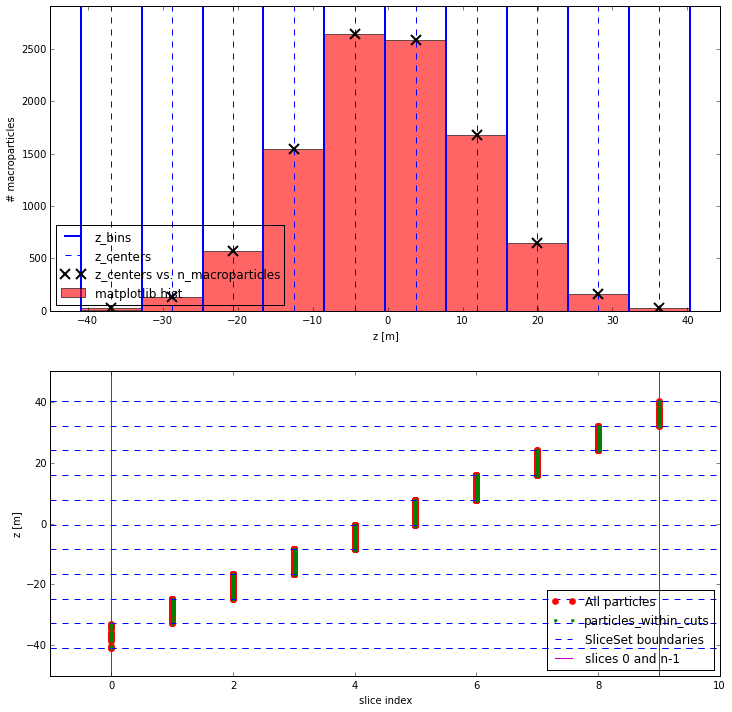

In [41]:
# CASE I
# UniformBinSlicer, no longitudinal cut.
n_slices = 10
n_sigma_z = None
uniform_bin_slicer = UniformBinSlicer(n_slices, n_sigma_z)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_bin_slicer config.
uniform_bin_slice_set = bunch.get_slices(uniform_bin_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_bin(bunch, uniform_bin_slice_set)

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformBinSlicer object at 0x7f5a5d637750>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7f5a5d2224d0>}


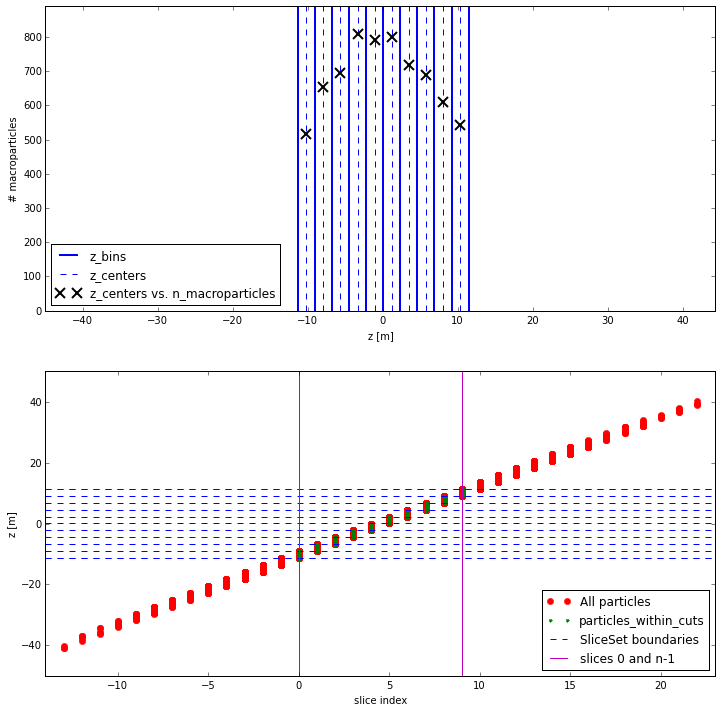

In [42]:
# CASE II
# UniformBinSlicer, n_sigma_z = 1
n_slices = 10
n_sigma_z = 1
uniform_bin_slicer = UniformBinSlicer(n_slices, n_sigma_z)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_bin_slicer config.
uniform_bin_slice_set = bunch.get_slices(uniform_bin_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_bin(bunch, uniform_bin_slice_set)

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformBinSlicer object at 0x7f5a5d20bc10>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7f5a5d3b9650>}


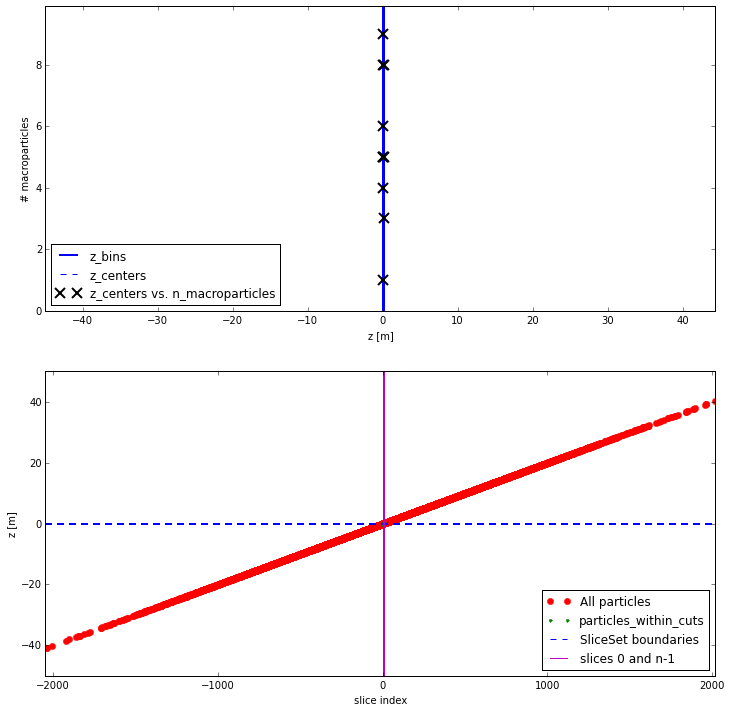

In [43]:
# CASE II b.
# UniformBinSlicer, set z_cuts
n_slices = 10
z_cuts = (-0.05, 0.15)
uniform_bin_slicer = UniformBinSlicer(n_slices, z_cuts=z_cuts)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_bin_slicer config.
uniform_bin_slice_set = bunch.get_slices(uniform_bin_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_bin(bunch, uniform_bin_slice_set)

In [44]:
# CASE II c.
# UniformBinSlicer, set z_cuts and n_sigma_z (THIS SHOULD FAIL).
n_slices = 10
z_cuts = (-0.05, 0.1)
n_sigma_z = 2
try:
    uniform_bin_slicer = UniformBinSlicer(n_slices, n_sigma_z=n_sigma_z, z_cuts=z_cuts)
    raise Exception('Expected ValueError because two incompatible arguments n_sigma_z and z_cuts are given!')
except ValueError:
    print ('Test passed.')

Test passed.


bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformChargeSlicer object at 0x7f5a5db143d0>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7f5a5d756bd0>}


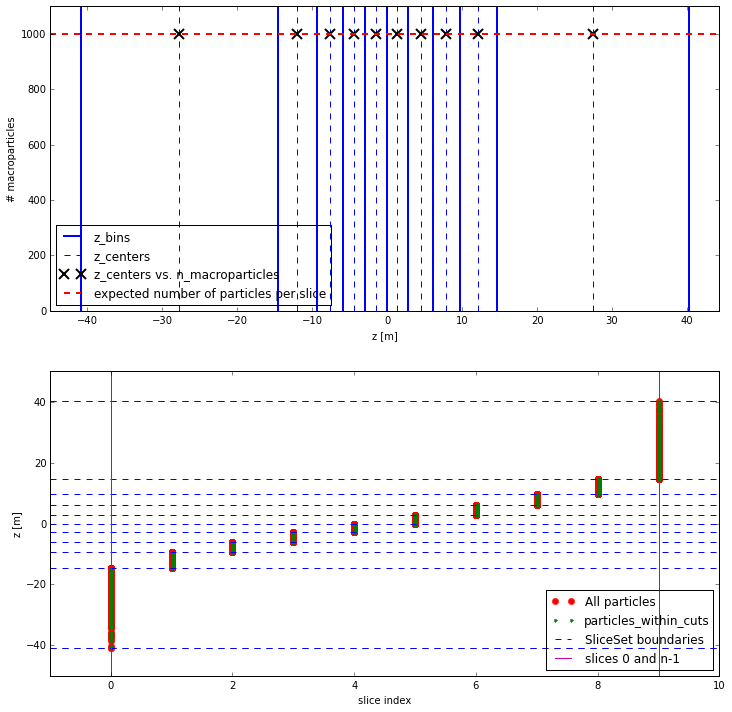

In [45]:
# CASE III
# UniformChargeSlicer, no longitudinal cut.
n_slices = 10
n_sigma_z = None
uniform_charge_slicer = UniformChargeSlicer(n_slices, n_sigma_z)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_charge_slicer config.
uniform_charge_slice_set = bunch.get_slices(uniform_charge_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_charge(bunch, uniform_charge_slice_set)

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformChargeSlicer object at 0x7f5a5dc88810>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7f5a5db143d0>}


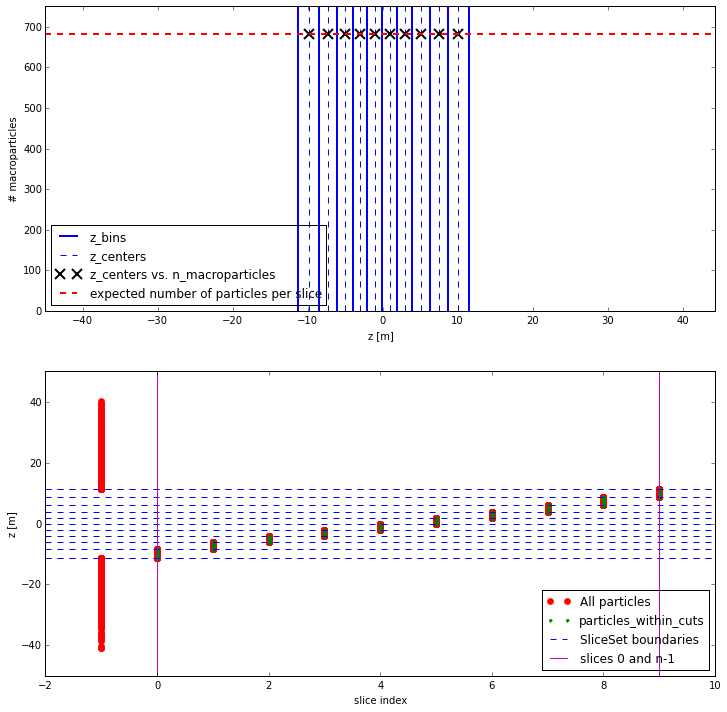

In [46]:
# CASE IV
# UniformChargeSlicer, n_sigma_z = 1
n_slices = 10
n_sigma_z = 1
uniform_charge_slicer = UniformChargeSlicer(n_slices, n_sigma_z)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_charge_slicer config.
uniform_charge_slice_set = bunch.get_slices(uniform_charge_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_charge(bunch, uniform_charge_slice_set)

bunch._slice_sets {}
bunch._slice_sets {<PyHEADTAIL.particles.slicing.UniformChargeSlicer object at 0x7f5a5d7cf490>: <PyHEADTAIL.particles.slicing.SliceSet object at 0x7f5a5dc88810>}


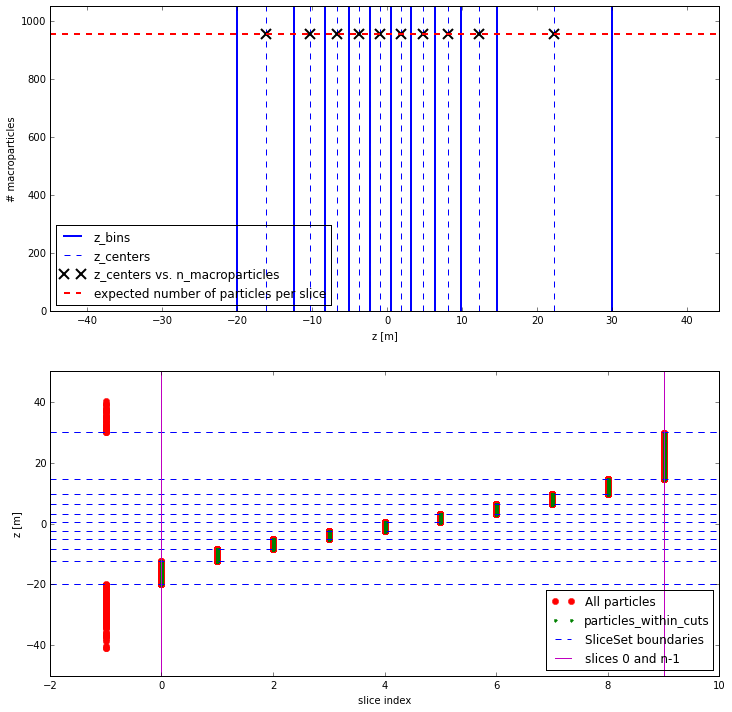

In [47]:
# CASE IV b.
# UniformChargeSlicer, set z_cuts
n_slices = 10
z_cuts = (-20, 30)
uniform_charge_slicer = UniformChargeSlicer(n_slices, z_cuts=z_cuts)

clean_bunch(bunch)

print 'bunch._slice_sets', bunch._slice_sets

# Request slice_set from bunch with the uniform_bin_slicer config.
uniform_charge_slice_set = bunch.get_slices(uniform_charge_slicer)
print 'bunch._slice_sets', bunch._slice_sets

plot_results_uniform_charge(bunch, uniform_charge_slice_set)

In [48]:
# CASE IV c.
# UniformChargeSlicer, set z_cuts and n_sigma_z (THIS SHOULD FAIL).
n_slices = 10
z_cuts = (-0.05, 0.1)
n_sigma_z = 2
try:
    uniform_charge_slicer = UniformChargeSlicer(n_slices, n_sigma_z=n_sigma_z, z_cuts=z_cuts)
    raise Exception('Expected ValueError because two incompatible arguments n_sigma_z and z_cuts are given!')
except ValueError:
    print ('Test passed.')

Test passed.
